This jupyter notebook is used to optimize maneuvers parameters using regression algorithms and gameplans parameters.


In [1]:
from objects.Plane import Plane
from objects.Maneuvers import *
from function import tools
from function.tools import KMH2KNOTS, KNOTS2KMH
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from keras import backend as K
from tensorflow.python.ops.numpy_ops import np_config
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, normalized_mutual_info_score
from scipy.optimize import Bounds
from scipy.optimize import minimize
np_config.enable_numpy_behavior()


In [2]:
ULM = Plane()
plane_list = [ULM]


Cet avion peut voler pendant  1182  s, soit  20  min à une vitesse moyenne de  150  km/h et sa vitesse max sera de  200  km/h


In [3]:
param_list = {
    'Plane': plane_list,  # Plane used in data
    # Distance from the starting point to the goal
    'GoalDistance': [0, 5, 10, 15, 20],
    # Distance from the objective to the exit point
    'RtBDistance': [0, 5, 10, 15, 20],
    # KG of fuel available at the start of the mission
    'Fuel': [300, 400, 400, 450, 500, 550],
    'Meteo': ["Sunny", "Cloudy", "Misty"],
    # Start with just 3 states : sunny (no clouds), cloudy and misty (cloudy++)
    'MissionType': [Mission_Maneuver.SCAR],
    # Type of mission : will change the mission context
    # , Mission_Maneuver.CAS
    # 'TimeMin': [None, 300],
    # Time constraint for the time on the objective
    # Add ennemies number afterwards, weaponry
    'Strength': ['Weak', 'Equal', 'Strong'],
    # 'Impredictibility' : [0, 50, 90], # Potential appearance of new ennemies on the objective point
}


In [4]:

all_combinations_not_filtered = tools.get_all_combinations(param_list)
all_combinations = []
for c in all_combinations_not_filtered:
    data = c['metadata']

    plane = data['Plane']
    if plane.name == 'M2000':
        data['Fuel'] *= 6
    elif plane.name == 'ULM':
        data['Fuel'] = round(data['Fuel'] / 6)

    # Check if the data corresponds to the plane caracteristics
    if plane.fuel_max >= data['Fuel']:
        # if plane.V_max < data['MaxSpeedOP']:
        #     data['MaxSpeedOP'] = plane.V_max
        all_combinations.append(data)

        


In [5]:
df = pd.DataFrame(all_combinations)
print(df.sample(10))


     Plane  GoalDistance  RtBDistance  Fuel   Meteo MissionType Strength
1063   ULM            15           20    83   Sunny        SCAR    Equal
24     ULM             0            0    67   Misty        SCAR     Weak
961    ULM            15           10    83   Misty        SCAR    Equal
32     ULM             0            0    75  Cloudy        SCAR   Strong
622    ULM            10            5    75   Sunny        SCAR    Equal
537    ULM             5           20    92   Misty        SCAR     Weak
860    ULM            15            0    92  Cloudy        SCAR   Strong
1239   ULM            20           10    92   Misty        SCAR     Weak
766    ULM            10           20    67   Sunny        SCAR    Equal
893    ULM            15            5    75   Sunny        SCAR   Strong


In [6]:
df = pd.get_dummies(df, columns=["Plane", "Meteo", "MissionType", "Strength"])
print(df.sample(10))

     GoalDistance  RtBDistance  Fuel  Plane_ULM  Meteo_Cloudy  Meteo_Misty  \
904            15            5    83          1             1            0   
763            10           20    50          1             0            1   
257             0           20    83          1             1            0   
122             0           10    67          1             1            0   
545            10            0    50          1             1            0   
618            10            5    67          1             0            1   
374             5            5    92          1             1            0   
153             0           10    92          1             0            0   
981            15           15    67          1             0            0   
642            10            5    92          1             1            0   

     Meteo_Sunny  MissionType_SCAR  Strength_Equal  Strength_Strong  \
904            0                 1               1                0   

In [7]:
all_c = all_combinations.copy()

for c in all_c:
    c['Maneuvers'] = []
    c['NameManeuvers'] = []
    c['FuelRemaining'] = c['Fuel']
    # while c['FuelRemaining'] > c['Fuel'] / 4 or Mission_Maneuver.getMinManeuver(c['MissionType']) not in c['NameManeuvers']:

# Changer pour ne pas avoir le y_pred
# Regression sur tous les paramètres des wheels
# Customiser propre fonction de loss et fonction de coût pour maximiser le temps / efficacité et minimiser fuel restant / fuel consommé
def custom_loss(layer):
    loss = 0
    return loss

def loss():
    def loss_mse(y_pred: list, y_true: list) -> float:
        new_loss_pde = K.mean(K.square(y_pred))
        return new_loss_pde
    return loss_mse

def loss_mse(y_true: list, y_pred: list) -> float:
    print(y_pred)
    wheels = []
    for c in y_pred:
        w = Wheel("Wheel", c[0], c[1], c[2])
        wheels.append(w.total_fuel_consumption(ULM))

    
    return tf.reduce_mean(wheels)

def l():
   
    return loss_mse

In [8]:
col_names = []
nb_params = 1
for i in range(nb_params):
    col_names.append("Y{}".format(i+1))
df_y = pd.DataFrame(K.zeros((df.shape[0], nb_params)), columns=col_names)

print(df.shape, df_y.shape)

# df = np.expand_dims(df, -1)
# df_y = np.expand_dims(df_y, -1)
X_train, X_test, y_train, y_test = train_test_split(df, df_y, test_size=0.30)
X_train = np.asarray(X_train).astype('float32')
y_train = np.asarray(y_train).astype('float32')
print(y_test.shape)

(1350, 11) (1350, 1)
(405, 1)


In [9]:
def compute_maneuver(speed : float, altitude : float, distance : float, iter : int = 1) :
    wheels = []
    for _ in range(iter):
        wheels.append(Wheel('Wheel', speed, altitude, distance))
    return sum(w.total_fuel_consumption(ULM) for w in wheels), sum(w.travelled_time() for w in wheels)

c0 : float = 130
c1: float = 15

def J(x0 : list):
    
    speed = x0[0]
    altitude = x0[1]
    distance = x0[2]
    # iter = math.floor(x0[3])
    fuel_c, time = compute_maneuver(speed, altitude, distance)
    # print(fuel_c, c0)
    return ((fuel_c - c0) ** 2)

bounds = Bounds([100,0.2,15],[200,3,30])

In [10]:
methods = ['Powell', 'Nelder-Mead', 'L-BFGS-B', 'TNC' ]
results = []
for method in methods : 

    result = minimize(J,(180,1,20) ,method= method, bounds = bounds)
    results.append(result)
    print(method)
    print(result.x)
    print(result.message)

Powell
[100.31681582   2.99998473  15.00000001]
Optimization terminated successfully.
Nelder-Mead
[100.   3.  15.]
Optimization terminated successfully.
L-BFGS-B
[180.   3.  15.]
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
TNC
[180.   3.  15.]
Local minimum reached (|pg| ~= 0)


In [11]:

results = zip(methods, results)
for method, result in results:
    print(method, result.x)
    w = Wheel('Wheel',result.x[0], result.x[1], result.x[2])
    print(w.total_fuel_consumption(ULM), w.travelled_time())

Powell [100.31681582   2.99998473  15.00000001]
753702.6964958895 282.3870969381138
Nelder-Mead [100.   3.  15.]
752480.2643839186 282.64864864864865
L-BFGS-B [180.   3.  15.]
1005084.6838105086 261.02702702702703
TNC [180.   3.  15.]
1005084.6838105086 261.02702702702703


In [12]:
def J(x0 : list) -> float:
    
    speed = x0[0]
    altitude = x0[1]
    distance = x0[2]
    # iter = math.floor(x0[3])
    fuel_c, time = compute_maneuver(speed, altitude, distance)
    
    # print(fuel_c, c0)
    return ((fuel_c - c0) ** 2) / time

def J_no_time(x0 : list) -> float:
    
    speed = x0[0]
    altitude = x0[1]
    distance = x0[2]
    # iter = math.floor(x0[3])
    fuel_c, time = compute_maneuver(speed, altitude, distance)
    # print(fuel_c)
    # print(fuel_c, c0)
    return ((fuel_c - c0) ** 2)


bounds_j = Bounds([100,0.2,15],[200,1,30])


results = []
for method in methods : 
    print(method)
    result = minimize(J_no_time,(180,0.6,20),method=method, bounds = bounds_j)
    results.append(result)
    
    print(result.x)
    print(result.message)
results = zip(methods, results)


Powell
[100.31696625   0.99995218  15.00000001]
Optimization terminated successfully.
Nelder-Mead
[100.   1.  15.]
Optimization terminated successfully.
L-BFGS-B
[180.   1.  15.]
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
TNC
[180.   1.  15.]
Local minimum reached (|pg| ~= 0)


In [13]:
for method, result in results:
    print(method, result.x) 
    w = Wheel('Wheel',result.x[0], result.x[1], result.x[2])
    print(w.total_fuel_consumption(ULM), w.travelled_time())

Powell [100.31696625   0.99995218  15.00000001]
754145.3706699543 282.3870969423966
Nelder-Mead [100.   1.  15.]
752921.6838234089 282.64864864864865
L-BFGS-B [180.   1.  15.]
1005783.8912073219 261.02702702702703
TNC [180.   1.  15.]
1005783.8912073219 261.02702702702703


In [14]:
def J_to_compute(x0 : list) -> float:
    # print(np.asarray(x0).shape)
    # print('X' , x0[0].shape)
    # print('Y',x0[1].shape)
    # print('Z', x0[2].shape)
    x = np.asarray(x0)
    # iter = math.floor(x0[3])
    # print(tools.get_combinations(x0))
    values = []
    for spd, alt, dis in zip(x[0], x[1], x[2]):
        fuel_c, time = compute_maneuver(spd, alt, dis) #,iter)
        values.append((fuel_c,time))
    values = np.array(values)
    
    # print(values.shape)
    return np.power((values[:,0] - c0), 2)  / values[:,1]

def J_to_compute_no_time(x0 : list) -> float:
    x = np.asarray(x0)
    values = []
    for spd, alt, dis in zip(x[0], x[1], x[2]):
        fuel_c, time = compute_maneuver(spd, alt, dis) #,iter)
        values.append((fuel_c,time))
    
    values = np.array(values)
    # print(values)
    # print(values.shape)
    return values[:,0] - c0# np.power((values[:,0] - c0), 2) 


X (49, 100, 46) Y (49, 100, 46) Z (49, 100, 46)
(49, 100, 46)


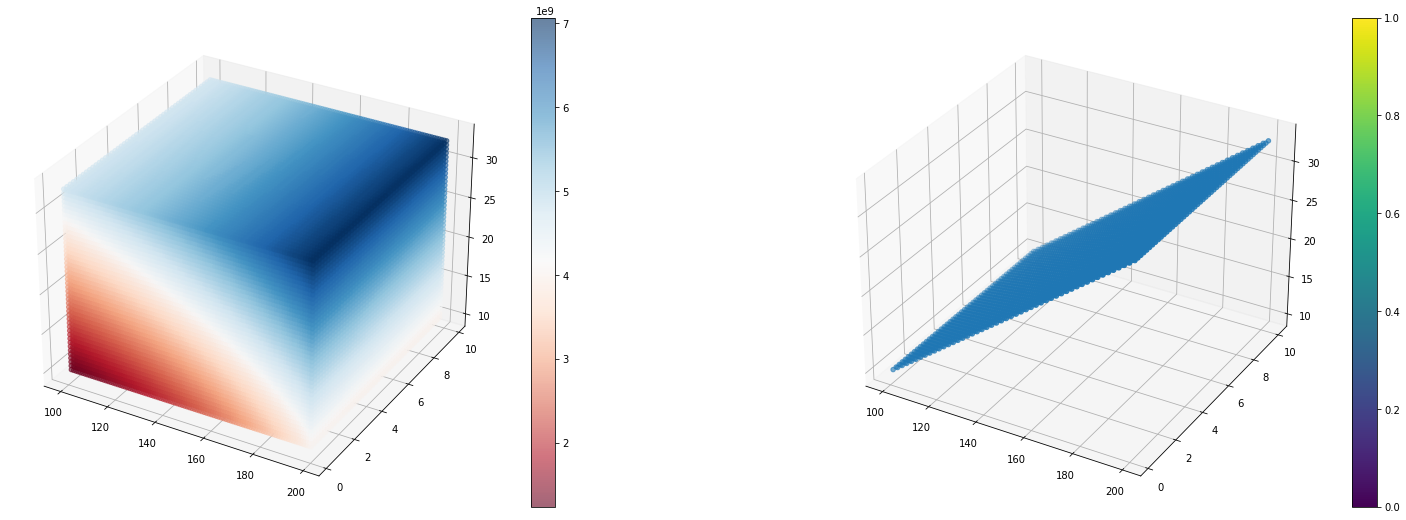

In [15]:
x= np.arange(100,200,1)
y= np.arange(0.2,10,0.2)
# y = [1]
z= np.arange(10, 33, 0.5)

# for c in all_c:
#     J(c)
# print(J_to_compute([x,y,z]).shape)
X, Y ,Z= np.meshgrid(x,y,z)
print("X",X.shape,"Y", Y.shape,"Z", Z.shape)
# print(np.asarray(tools.get_combinations([x,y,z])))
# print([X,Y,Z])
# print(X.shape, Y.shape)
# print('X',X)
# print('Y', Y )#,'Z', Z)
# data = np.asarray(list(zip(x,y,z)))
# print(data.shape, np.asarray(list(zip(X,Y,Z))).shape)
# J_function = J(data)
# plt.imshow(J_function)
def JJ(X,Y,Z):
    mat = []
    for i,f in enumerate(zip(X,Y,Z)):
        x,y,z = f
        mat.append([])
        for x1,y1,z1 in zip(x,y,z):
            mat[i].append(J_to_compute([x1,y1,z1]))
    return np.asarray(mat)



print(JJ(X,Y,Z).shape)
fig = plt.figure(figsize = (27,9))
ax1 = fig.add_subplot(1,2,1,projection='3d')

color_map = plt.get_cmap('RdBu')
ax1 = ax1.scatter3D(X,Y,Z, c = JJ(X,Y,Z), alpha = 0.6, cmap=color_map)
ax1.set_label('Speed')
ax1.set_label('Altitude')
ax1.set_label('Distance')
plt.colorbar(ax1)
x= np.linspace(100,200,50)
y= np.linspace(0.2,10,50)
# y = [1]
z= np.linspace(10, 33, 50)
Xi, Yi = np.meshgrid(x,y)

color_map = plt.get_cmap('RdBu')
ax2 = fig.add_subplot(1,2,2,projection='3d')
z = [z for _ in range(len(z))]
ax2 = ax2.scatter3D(Xi,Yi,z,  cmap =color_map)

plt.colorbar(ax2)
# ax3 = fig.add_subplot(1,3,3,projection='3d')

# ax3 = ax3.scatter3D(x, y, z, c=J_to_compute([x,y,z]), cmap=color_map)

# plt.colorbar(ax3)
plt.show()

In [16]:




def J_to_compute_noZ(X,Y,Z):
    res = []
    for i, row in enumerate(list(zip(X,Y))):
        x,y = row
        res.append([])
        for xi,yi,zi in zip(x,y,Z):
            res[i].append(J([xi,yi,zi]))
    return res


def J_to_compute_noZ_no_time(X,Y,Z):
    res = []
    for i, row in enumerate(list(zip(X,Y))):
        x,y = row
        res.append([])
        for xi,yi,zi in zip(x,y,Z):
            res[i].append(J_no_time([xi,yi,zi]))
    return res



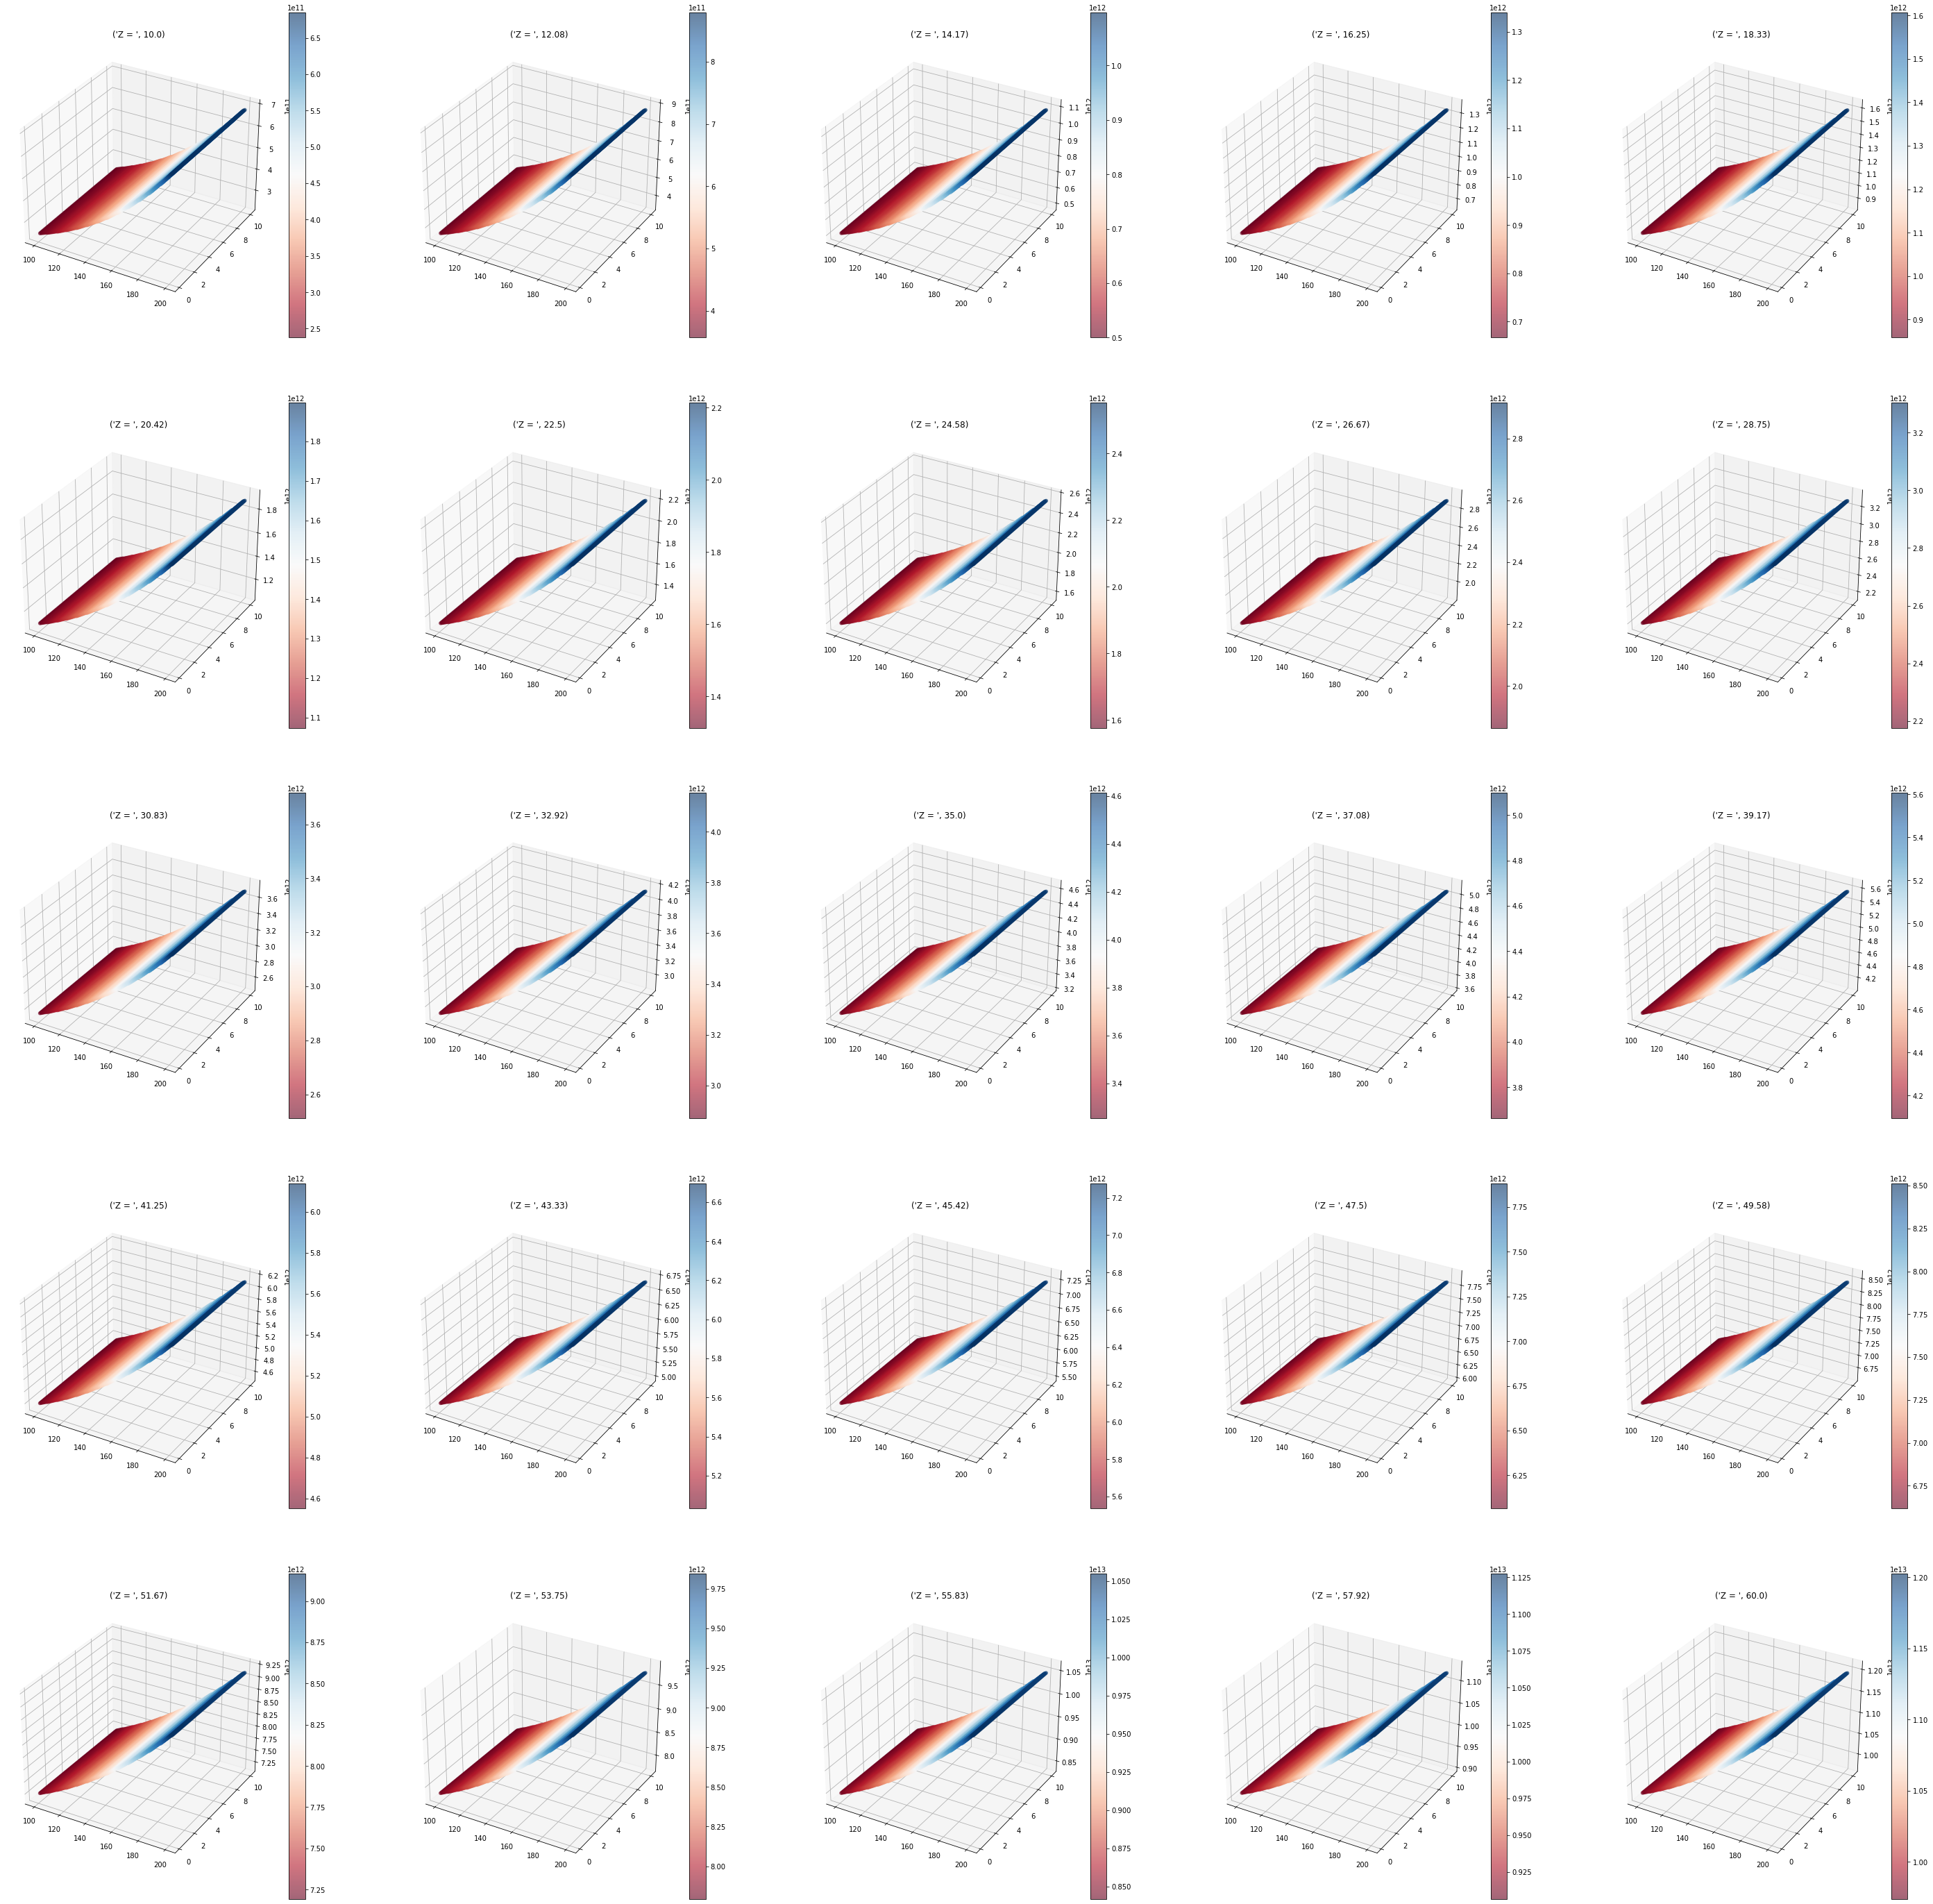

In [17]:
nb_value = 100
x= np.linspace(100,200,nb_value)
y= np.linspace(0.2,10,nb_value)
# y = [1]
X, Y = np.meshgrid(x,y)
num_graph = 25
num_col_row = int(math.sqrt(num_graph))
fig = plt.figure(figsize = (10 * num_col_row, 10 * num_col_row))
z= np.linspace(10, 60, num_graph)

for i,zi in enumerate(z):
    
    ax1 = fig.add_subplot(num_col_row,num_col_row,i+1,projection='3d')
    z = [zi for _ in range(nb_value)]
    # print(J_to_compute_noZ_no_time(X,Y,z))

    color_map = plt.get_cmap('RdBu')
    ax1 = ax1.scatter3D(X,Y,J_to_compute_noZ_no_time(X,Y,z), c= J_to_compute_noZ_no_time(X,Y,z), alpha = 0.6, cmap = color_map)
    ax1.set_label('Speed')
    ax1.set_label('Altitude')
    ax1.set_label('Distance')
    plt.title(("Z = ", round(zi,2)))
    plt.colorbar(ax1)

In [18]:

print(J_no_time([200,20,49]))
print(J_no_time([100,20,49]))
x = 200

8237281404326.622
6424589625720.361
